De même que pour le CNN , nous avons le même SVM pour la modulation et les spectro afin de comparer équitablement.


Importation des bibliothèques

In [24]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import csv
from sklearn import preprocessing
from sklearn.metrics import precision_score


Importation du corpus train et test pour la classe malade et sain

In [25]:
# Fonction pour charger et prétraiter les images
def load_and_preprocess_data(folder_path, label, img_rows=28, img_cols=28):
    images = []
    labels = []

    for filename in os.listdir(folder_path):
        path = os.path.join(folder_path, filename)
        img = cv2.imread(path, 0).astype(np.uint8)
        img = cv2.resize(img, (img_rows, img_cols))
        images.append(img.flatten())
        labels.append(label)

    return images, labels

# pour 'malade' and 'non_malade' classes
malade_train_path = 'phonétique1/malade_spectro_glides/train'
malade_test_path = 'phonétique1/malade_spectro_glides/test'

non_malade_train_path = 'phonétique1/sain_spectro_glides/train'
non_malade_test_path = 'phonétique1/sain_spectro_glides/test'

# 'malade' train
malade_train_images, malade_train_labels = load_and_preprocess_data(malade_train_path, label=0)

# 'non_malade' train
non_malade_train_images, non_malade_train_labels = load_and_preprocess_data(non_malade_train_path, label=1)

# 'malade' test
malade_test_images, malade_test_labels = load_and_preprocess_data(malade_test_path, label=0)

# 'non_malade' test
non_malade_test_images, non_malade_test_labels = load_and_preprocess_data(non_malade_test_path, label=1)


x_train = np.concatenate([malade_train_images, non_malade_train_images], axis=0)
y_train = np.concatenate([malade_train_labels, non_malade_train_labels], axis=0)

x_test = np.concatenate([malade_test_images, non_malade_test_images], axis=0)
y_test = np.concatenate([malade_test_labels, non_malade_test_labels], axis=0)

scaler = preprocessing.StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)


Créer et entraîner le modèle SVM et visualiser la matrice de confusion

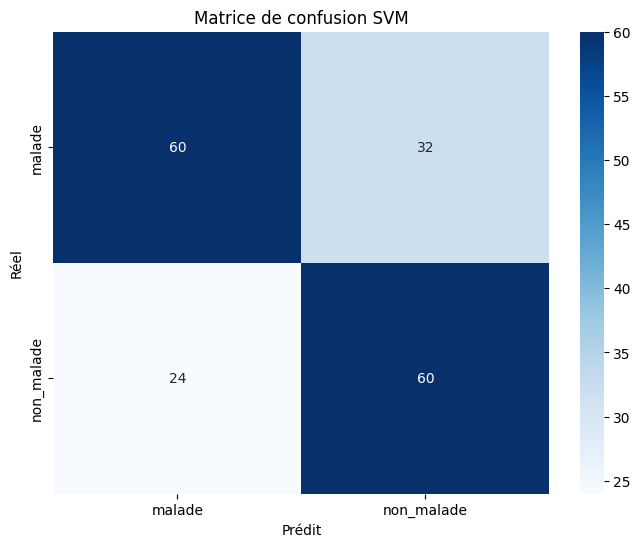

Precision: 0.6522


In [26]:
svm_model = SVC(kernel='rbf', C=1, gamma='scale')
svm_model.fit(x_train_scaled, y_train)

# Prédictions
y_pred_svm = svm_model.predict(x_test_scaled)

# Matrice de confusion
conf_mat_svm = confusion_matrix(y_test, y_pred_svm)

# Visualiser
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['malade', 'non_malade'], yticklabels=['malade', 'non_malade'])
plt.title('Matrice de confusion SVM')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()

# Calculer precision
precision = precision_score(y_test, y_pred_svm)
print(f'Precision: {precision:.4f}')

les données mal classées

In [27]:
# Obtenir les noms de fichiers d'images pour 'malade' et 'non_malade'
malade_image_names = [os.path.basename(os.path.join(malade_path, 'train', filename)) for filename in os.listdir(os.path.join(malade_path, 'train'))]
non_malade_image_names = [os.path.basename(os.path.join(non_malade_path, 'train', filename)) for filename in os.listdir(os.path.join(non_malade_path, 'train'))]

# Sauvegarder les données mal classées dans un fichier CSV
misclassified_data_svm = []
for i in range(len(y_test)):
    if y_test[i] != y_pred_svm[i]:
        actual_class = 'malade' if y_test[i] == 0 else 'non_malade'
        predicted_class = 'malade' if y_pred_svm[i] == 0 else 'non_malade'
        image_name = malade_image_names[i] if i < len(malade_image_names) else non_malade_image_names[i - len(malade_image_names)]
        misclassified_data_svm.append([image_name, actual_class, predicted_class])

csv_file_path_svm = '/content/drive/MyDrive/phonétique1/misclassified_data_svm.csv'
header_svm = ['Nom de l\'image', 'Classe Réelle', 'Classe Prédite']

with open(csv_file_path_svm, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header_svm)
    writer.writerows(misclassified_data_svm)

print(f"Données mal classées sauvegardées dans le fichier CSV : {csv_file_path_svm}")

# Afficher les données mal classées
res_svm = pd.DataFrame(misclassified_data_svm)
print(res_svm)

Données mal classées sauvegardées dans le fichier CSV : /content/drive/MyDrive/phonétique1/misclassified_data_svm.csv
                                                    0           1           2
0   spectrogram_SCA_H_AB04_2017_01_09_ModuleTransi...      malade  non_malade
1   spectrogram_SCA_H_AB04_2017_01_09_ModuleTransi...      malade  non_malade
2   spectrogram_SCA_H_AB04_2017_01_09_ModuleTransi...      malade  non_malade
3   spectrogram_SCA_H_AB07_2020_10_26_ModuleTransi...      malade  non_malade
4   spectrogram_SCA_H_AB07_2020_10_26_ModuleTransi...      malade  non_malade
5   spectrogram_SCA_H_AB07_2020_10_26_ModuleTransi...      malade  non_malade
6   spectrogram_SCA_H_AB07_2020_10_26_ModuleTransi...      malade  non_malade
7   spectrogram_SCA_H_AB07_2020_10_26_ModuleTransi...      malade  non_malade
8   spectrogram_SCA_H_AB07_2020_10_26_ModuleTransi...      malade  non_malade
9   spectrogram_SCA_H_AB07_2020_10_26_ModuleTransi...      malade  non_malade
10  spectrogram_SNC_F_A

Le SVM s'en sort beaucoup moins bien que le spectrogramme pour la classification, particulièrement pour les malades. il y a un ecart de 15 \% avec la modulation ce qui n'est pas rien. L'ecart est beaucoup plus grand qu'avec le CNN ou nous n'avons que 5\% d'écart entre les deux inputs.